### Importing Libraries

In [73]:
# importing libraries
import numpy as np
import scipy
from scipy import interpolate
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline
import IPython.display 
import librosa
import librosa.display
import essentia
import essentia.standard as es
np.set_printoptions(threshold='nan')

### Import multi-track, generate STFT matrix

In [74]:
# initialising STFT params
sr = 44100.0
N = 2**15 #FFT size = 32768
M = N     #window size 
H = M/64  #hop size
W = np.hanning(M)

#tracks to extract, unpan track to the end
# tracks = ['piano', 'gui_ac','gui_el','cello','voc_h','voc','drum','bass']
tracks = ['organ', 'gui_ac','gui_el','voc_h','epiano','voc']

# initialising arrays needed
# track = [[],[],[],[],[],[],[],[]]
# stft = [[],[],[],[],[],[],[],[]]
# mx = [[],[],[],[],[],[],[],[]]
# px = [[],[],[],[],[],[],[],[]]
# spec_avg = [[],[],[],[],[],[],[],[]]
track = [[],[],[],[],[],[]]
stft = [[],[],[],[],[],[]]
mx = [[],[],[],[],[],[]]
px = [[],[],[],[],[],[]]
spec_avg = [[],[],[],[],[],[]]
indend = 1500# N/2+1
for t in range(0,len(tracks)):
    track[t],sr = librosa.load('../samples/phrases2c/'+tracks[t]+'.wav', sr = sr, mono = 'True')
    stft[t] = librosa.stft(y = track[t], n_fft = N,win_length=M, hop_length=H, window = 'hann')   
    mx[t], px[t] = librosa.magphase(stft[t])
    mx[t] =  mx[t] / np.sum(W) #normlaising STFT output
    spec_avg[t] = np.average(mx[t],axis=1) 
    spec_avg[t] = spec_avg[t]/np.max(spec_avg[t])
#     plt.figure(figsize=(16,2))
#     plt.plot(spec_avg[t][0:indend])
#     plt.title(tracks[t])
#     plt.show()
print np.shape(spec_avg)     
print np.shape(stft[0])

(6, 16385)
(16385, 1637)


### Similarity index correlation map

In [75]:
def coh(mx, my):
    return np.multiply(mx,my)
def simfn(s1,s2):
    return np.average(2.0 * np.divide (np.abs(coh(s1,s2)) , np.add(coh(s1,s1),coh(s2,s2)) ))
def smfn(s1,s2):
    return np.sum(np.square(s1)-np.square(s2))
def smbfn(s1,s2):
    return np.sum(np.clip(np.sign(np.square(s1) - np.square(s2)),0,1))

numpan = 5
cor_avg = np.zeros((numpan,numpan))

#calculating similarity index correlation map
print tracks
for i in range(0,numpan):
    for j in range(0,numpan):
        s1 = spec_avg[i] #np.transpose(mX[i])[51] 
        s2 = spec_avg[j] #np.transpose(mX[j])[51]
        cor_avg[i][j] = smfn(s1,s2)
               
lt = np.tril_indices(numpan)
ut = np.triu_indices(numpan)
cor_avg[ut] = 0
inds = np.transpose(np.where(cor_avg!=0))
cor_low_tri = np.flip(np.sort(cor_avg[lt]),0)
cor_low_tri = np.delete(cor_low_tri,np.where(cor_low_tri==0))
indstack = [[0,0,0]]
for i in range(0,np.size(inds)/2):
    ind = np.where(cor_avg==cor_low_tri[i])
    print tracks[ind[0][0]],'\t',tracks[ind[1][0]],'\t', cor_avg[ind[0][0]][ind[1][0]]
    ind_temp = ind[0][0],ind[1][0],cor_avg[ind[0][0]][ind[1][0]]
    indstack = np.vstack((indstack,ind_temp))    
# print indstack[1:]

a_u = indstack[1:,0:2].flatten() 
iu = np.unique(a_u, return_index=True)[1]
ui = [int(a_u[index]) for index in sorted(iu)]
# ui = np.append(ui,[5,6,7])
ui = np.append(ui,[5])
print ui,[tracks[ui[i]] for i in range(0,numpan)]

['organ', 'gui_ac', 'gui_el', 'voc_h', 'epiano', 'voc']
gui_el 	organ 	14.668119430541992
gui_el 	gui_ac 	11.345575332641602
gui_ac 	organ 	3.322545289993286
epiano 	voc_h 	-0.7093695998191833
voc_h 	organ 	-11.13459587097168
epiano 	organ 	-11.843966484069824
voc_h 	gui_ac 	-14.457143783569336
epiano 	gui_ac 	-15.166513442993164
voc_h 	gui_el 	-25.802719116210938
epiano 	gui_el 	-26.512086868286133
[2 0 1 4 3 5] ['gui_el', 'organ', 'gui_ac', 'epiano', 'voc_h']


### Panning envelope generation

In [ ]:
def env(x,k,a,b):
    envelope = k * 1/(1+np.exp(a+b*x))
    return envelope #np.transpose(np.matlib.repmat(envelope, np.size(stft[0],axis=1), 1))

def pan(factor,freq,order,shift,start,attn,s):
    
    n = N/2 + 1
    start = int(start)
    #start = 100
    stop  = n
    freq = factor*freq#np.linspace(20,20000,n)
    w = order#0.01
    mels = w * 2595 * np.log10(1 + (freq+shift)/700) #/700 acc to formula
    x_mels = 2595 * np.log10(1 + (freq)/700)

    l1_start = 1.0 #fix
    l1_stop = 1.0

    l2_start = 1.0
    l2_stop = attn

    wave = np.zeros(n)
    bins = np.arange(0,n)
    x_bins = np.arange(0,stop-start)
    envelope = env(bins,1.0,900/100, -0.007)
    wave[start:stop] = np.sin(mels[start:stop])
    line1 = ((bins-stop)*(l1_stop-l1_start))/(stop-start)+l1_stop
    line2 = ((bins-stop)*(l2_stop-l2_start))/(stop-start)+l2_stop
    pan_filter = (envelope*wave*line1*line2 + 1.0)/2.0
    pan_filter = scipy.ndimage.shift(pan_filter, shift, output=None, order=3, mode='mirror', cval=0.5, prefilter=True)
    pan_filter = scipy.ndimage.shift(pan_filter, s, output=None, order=3, mode='constant', cval=0.5, prefilter=True)
    return pan_filter

n = N/2 + 1
freq = np.linspace(20,20000,n)
x_mels = 2595 * np.log10(1 + (freq)/700)

#       f,freq,order,shift,start,attn,s
f =     [1.0,0.7,0.8,0.9,1.2]
order = [0.01,0.01,0.01,0.01,0.01]
shift = [100,-200,-400,-50,50]
start = [0,0,100,0,100]
attn =  [1.0,1.0,1.0,1.0,1.0]
s =     [0,200,100,50,0]
#        b, g,  r, p, b
pf = [[],[],[],[],[]]

for i in range(0,5):
    pf[i] = pan(f[i],freq,order[i],shift[i],start[i],attn[i],s[i])
    pf[i] = np.transpose(np.matlib.repmat(pf[i], np.size(stft[0],axis=1), 1))
    
plt.figure(figsize=(16,2))  
plt.title("Panning envelopes")
for i in range(len(pf)): plt.plot(pf[i])    
plt.show() 

bins = np.arange(0,n)
envelope = env(bins,1.0,900/100, -0.007)
plt.plot(envelope)  

### Panning envelope multiplication with spectrum 

In [77]:
myL = np.copy(mx)
myR = np.copy(mx)

for i in range(0,numpan):
    # with sine-cosine panning law
    myL[ui[i]] = np.multiply ( np.cos(pf[i]*(np.pi/2.0)) , myL[ui[i]] )
    myR[ui[i]] = np.multiply ( np.sin(pf[i]*(np.pi/2.0)) , myR[ui[i]] )
    
    #without panning law
#     if (i%2):
#             myL[ui[i]] = np.transpose(np.transpose(myL[ui[i]])*np.matlib.repmat(pf[i], np.size(stft[0],axis=1),1))
#             myR[ui[i]] = np.transpose(np.transpose(myR[ui[i]])*np.matlib.repmat((-1.0*pf[i])+1.0, np.size(stft[0],axis=1),1))
#     else:
#             myR[ui[i]] = np.transpose(np.transpose(myR[ui[i]])*np.matlib.repmat(pf[i], np.size(stft[0],axis=1),1))
#             myL[ui[i]] = np.transpose(np.transpose(myL[ui[i]])*np.matlib.repmat((-1.0*pf[i])+1.0, np.size(stft[0],axis=1),1))

myL[ui[5]] = 0.25*myL[ui[5]] #np.multiply ( np.cos(pf[0]*(np.pi/2.0)) , myL[ui[5]] )
myR[ui[5]] = 0.25*myR[ui[5]] #np.multiply ( np.sin(pf[0]*(np.pi/2.0)) , myR[ui[5]] )
numpan = 6#len(tracks) 
for i in range(0,numpan):
    myL[ui[i]] = myL[ui[i]] * np.exp(1j*np.angle(px[ui[i]]))    
    myR[ui[i]] = myR[ui[i]] * np.exp(1j*np.angle(px[ui[i]])) 

myLt, myRt = myL[ui[i]],myR[ui[i]]

for i in range(1,numpan):
    myLt = myLt + myL[ui[i]]
    myRt = myRt + myR[ui[i]]
    
Y1 = librosa.istft(myLt, hop_length = H, win_length = M, window = W, center = 'False')
Y2 = librosa.istft(myRt, hop_length = H, win_length = M, window = W, center = 'False')
# Yv = librosa.istft(myL[int(uni_ind[4])], hop_length = H, win_length = M, window = W, center = 'False')
            

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:22: ComplexWarning: Casting complex values to real discards the imaginary part


### Left spectrum

In [78]:
import IPython.display as ipd
ipd.Audio(Y1, rate=sr)

### Right spectrum 

In [79]:
ipd.Audio(Y2, rate=sr)

### Synthesised stereo

In [80]:
# librosa.output.write_wav('my_algo.wav', Y, sr)
y = [Y1,Y2]
librosa.output.write_wav('myalgo_mix.wav', np.transpose(y), sr, norm = True)
ipd.Audio(y, rate=sr)

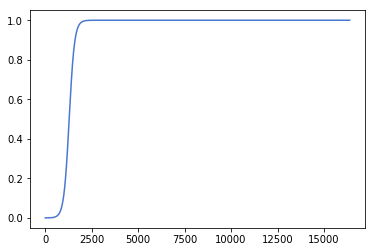

In [90]:
bins = np.arange(0,n)
envelope = env(bins,1.0,900/100, -0.007)
plt.plot(envelope)  
